# Machine Learning Project - Connect 4 Database

# HOUSSENALY Ali - GUILLARME Côme

This notebook presents the approach we took to exploit the UC Irvine Connect 4 Database.

We dive deeper in the data content and our objective once the visualisation is done.

In this notebook, you might be asked if you want to train or load models. This was done so that you don't have to train the models each time you reload the notebook.

## 0 - Import libraries and dataset

In [78]:
# Import modules
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

import os
import joblib


# Plotting style
ftsize_title = 20
ftsize_axis = 16
sns.set_style('whitegrid')
sns.set_palette("viridis")

In [3]:
# Fetch dataset from UCI repository
connect_4 = fetch_ucirepo(id=26)

## 1 - Understand the dataset

### 1a - Visualize the dataset

In [4]:
# Convert to DataFrame
df = pd.DataFrame(connect_4.data.features, columns=connect_4.feature_names)
df['target'] = connect_4.data.targets

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67557 entries, 0 to 67556
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   a1      67557 non-null  object
 1   a2      67557 non-null  object
 2   a3      67557 non-null  object
 3   a4      67557 non-null  object
 4   a5      67557 non-null  object
 5   a6      67557 non-null  object
 6   b1      67557 non-null  object
 7   b2      67557 non-null  object
 8   b3      67557 non-null  object
 9   b4      67557 non-null  object
 10  b5      67557 non-null  object
 11  b6      67557 non-null  object
 12  c1      67557 non-null  object
 13  c2      67557 non-null  object
 14  c3      67557 non-null  object
 15  c4      67557 non-null  object
 16  c5      67557 non-null  object
 17  c6      67557 non-null  object
 18  d1      67557 non-null  object
 19  d2      67557 non-null  object
 20  d3      67557 non-null  object
 21  d4      67557 non-null  object
 22  d5      67557 non-null

The dataset looks clean ! No missing values, no null values.

Let's represent a given row of the data

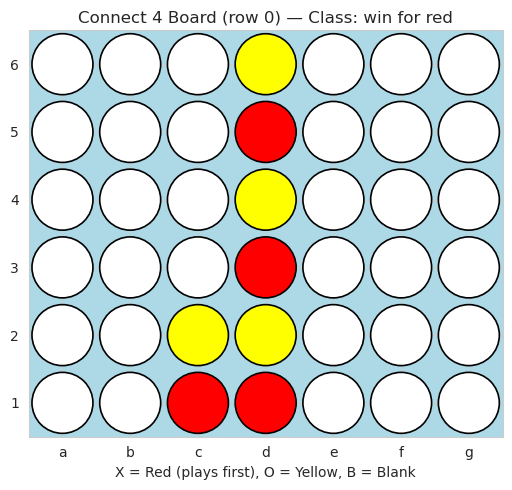

In [20]:
def visualize_connect4(df, row_index):
    """
    Visualize a Connect 4 board from a given row of the Connect4 dataset using matplotlib.
    
    Args:
        df (pd.DataFrame): The Connect4 dataset loaded as a pandas DataFrame.
        row_index (int): Index of the row to visualize.
    """
    # Extract the 42 board cells
    row = df.iloc[row_index, :42].values

    # Map values to colors
    color_map = {'x': 'red', 'o': 'yellow', 'b': 'white'}
    colors = np.array([color_map[val] for val in row])

    # Reshape into (6 rows, 7 columns)
    # Each column has 6 cells from bottom (1) to top (6)
    board = colors.reshape(7, 6).T  # shape (6,7)
    
    # Flip vertically to display row 6 at the top
    board = np.flipud(board)

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_aspect('equal')
    
    # Draw the grid and colored discs
    for r in range(6):
        for c in range(7):
            circle = plt.Circle((c, r), 0.45, color=board[r, c], ec='black', lw=1.2)
            ax.add_patch(circle)
    
    # Style grid
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_xticks(range(7))
    ax.set_xticklabels(list("abcdefg"))
    ax.set_yticks(range(6))
    ax.set_yticklabels(list(range(6, 0, -1)))
    ax.set_title(f"Connect 4 Board (row {row_index}) — Class: {df.iloc[row_index, 42]} for red")
    ax.set_xlabel('X = Red (plays first), O = Yellow, B = Blank')
    ax.set_facecolor('lightblue')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

visualize_connect4(df, 0)


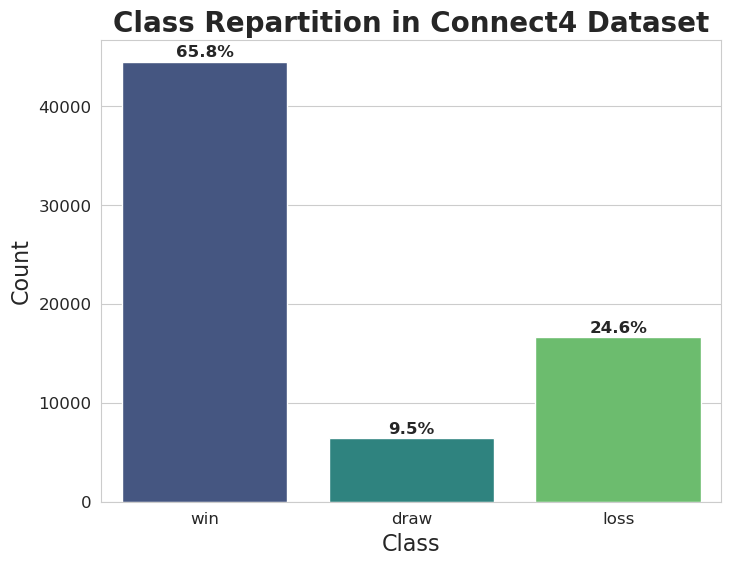

In [70]:
# Plot class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=df, palette='viridis', hue='target', dodge=False)

# Title and axis labels
plt.title('Class Repartition in Connect4 Dataset', fontsize=ftsize_title, fontweight='bold')
plt.xlabel('Class', fontsize=ftsize_axis)
plt.ylabel('Count', fontsize=ftsize_axis)
plt.xticks(fontsize=ftsize_axis-4)
plt.yticks(fontsize=ftsize_axis-4)

# Annotate each bar with percentage
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 500,
        percentage,
        ha='center',
        fontsize=ftsize_axis - 4,
        fontweight='bold'
    )

plt.show()

We observe heavy class imbalance. We will have to deal with this in the model training part.

### 1b - Dataset understanding
From this representation, we understand better the dataset and our objective.

From the description of the dataset in UC Irvine we get : "*This database contains all legal 8-ply positions in the game of connect-4 in which neither player has won yet, and in which the next move is not forced. x is the first player; o the second. The outcome class is the game theoretical value for the first player.*"


This means that the dataset includes **every possible board configuration that can arise after exactly 8 legal moves** (plies) have been made, under these constraints:
- **Legal**: The moves follow the rules of Connect-4 — no floating discs, no overfilled columns.
- **No win yet**: Neither player has already won after 8 plies.
- **No forced move**: The next player has at least two legal options — i.e., they’re not forced to play in a single column.
Each position is labeled with its game-theoretical value (win, loss, or draw for player x), assuming **perfect play** from both sides.

From the example displayed above we see that red (ie player x) will win because he can place a disc in b1 or e1 and yellow (player o) will have to counter with respectively a1 or f1 leading red to victory because e1 or b1 will be open positions.

### 1c - Our objective
From this understanding we can define our objective : **Build a classification model that predicts the outcome (win, loss, or draw) for player X based on the board state**. This dataset is perfect for a supervised learning approach !

## 2 - Model Training with naive approach

Let's try to train models directly. We will call this the naive approach because we didn't do any feature engineering or data rebalancing despite the heavy imbalance.

### 2a - Data Encoding and display function

In [71]:
# Useful display function
def performance_display(y_test, y_pred, title):
    """Function that displays a beautiful confusion matrix

    Args:
        y_test (pd.DataFrame): True label values of testing set
        y_pred (pd.DataFrame): Predicted label values of testing set
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted', fontsize=ftsize_axis)
    plt.ylabel('Actual', fontsize=ftsize_axis)
    # Invert y axis
    plt.gca().invert_yaxis()
    title = 'Confusion Matrix - ' + title
    plt.title(title, fontsize=ftsize_title, fontweight='bold')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true=y_test, y_pred=y_pred)
    print('Classification Report:')
    print(report)

We have to encode our inputs. Indeed, ML models can't take as input string values like "x", "o" or "b". Therefore we encode that data.

Here we choose **One Hot Encoding**. This attributes a binary value for each of our category. 

Each feature is replaced by 3 features.
"x" --> (1, 0, 0)
"o" --> (0, 1, 0)
"b" --> (0, 0, 1)

We use this type of encoding instead of the more simple ordinal encoding because ordinal encoding can mislead models by introducing a false sense of order in the data.

In [ ]:
# Encode board positions
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df.iloc[:, :42])
print(X_encoded.shape)

# Target
y = df['target']

# Train/test split
# We choose to stratify to ensure class proportions are maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y)

(67557, 126)


### 2b - Random Forest

Training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...................................n_estimators=200; total time= 2.4min
[CV] END ...................................n_estimators=200; total time= 2.4min
[CV] END ...................................n_estimators=200; total time= 2.4min
[CV] END ...................................n_estimators=200; total time= 2.4min
[CV] END ...................................n_estimators=200; total time= 2.4min
Model saved to models/rf.pkl

Best parameters for Random Forest: {'n_estimators': 200}
Best score for Random Forest: 0.8242445301839199


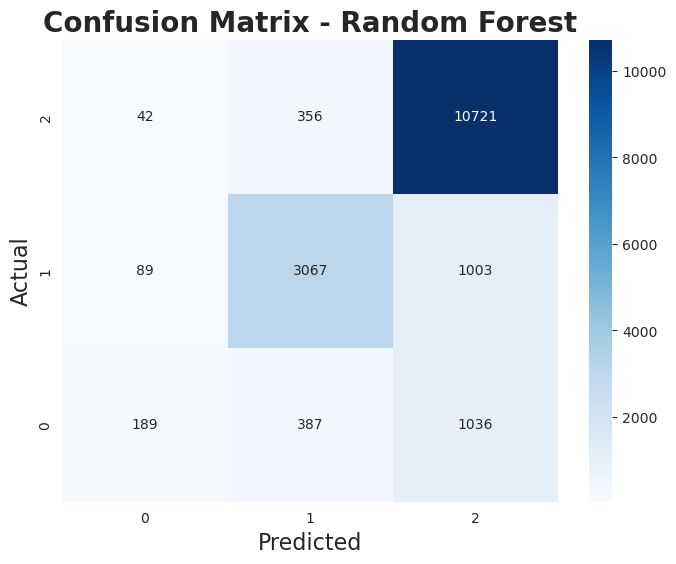

Classification Report:
              precision    recall  f1-score   support

        draw       0.59      0.12      0.20      1612
        loss       0.80      0.74      0.77      4159
         win       0.84      0.96      0.90     11119

    accuracy                           0.83     16890
   macro avg       0.75      0.61      0.62     16890
weighted avg       0.81      0.83      0.80     16890



In [79]:
choice = input("Do you want to train the Random Forest model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter model filename to create or load (e.g., rf.pkl): ").strip()

model_path = os.path.join("models", model_name)

if os.path.exists(model_path):
    overwrite = input(f"{model_name} already exists. Overwrite? (y/n): ").strip().lower()
    if overwrite == 'y':
        print("Overwriting the existing model.")
        choice = 'train'
    else:
        print("Loading the existing model.")
        choice = 'load'

if choice == 'train':
    
    print("Training the model...")

    # Define the parameter grid for Random Forest
    param_grid_rf = {
        'n_estimators': [200],
        # 'max_depth': [None, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the classifiers
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV for Random Forest
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

    # Perform grid search for Random Forest
    grid_search_rf.fit(X_train, y_train)

    # Save or overwrite
    joblib.dump(model_name, model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

    # Evaluate the best Random Forest model on the test set
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_pred_proba_rf = best_rf.predict_proba(X_test)[:,1]

    performance_display(y_test, y_pred_rf, "Random Forest")
    

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_rf = model.predict(X_test)
        performance_display(y_test, y_pred_rf, "Loaded Random Forest Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

### 2c - SVM and others ...

## 3 - Model training after handling data imbalance

## 4 - Model training after handling data imbalance and after performing feature engineering

## 5 - Overall comparison and conclusion